# Homework 6: Neural Language Models

## Total Points: 48+5
- **Overview**: In this assginment, we’ll be moving on from traditional n-gram based language models to more advanced forms of language modeling using *neural networks*. Additionally, we will learn how to build a character-level recurrent neural network, known as a char-RNN for short, with a famous Python package - PyTorch.

  This assignment is divided into 2 sections:
  1. Classify simple and hard words
  2. Classify city names to country
  
  Following our instructions,  you will implement your own char-RNN, and learn how it can deal with classification problems.  
  

- **FAQs:** Please look at the FAQ section before you start working:
  - **How do I save a PyTorch model?**

    After you trained your PyTorch model, the command below will save your model to the local directory. Please ensure that your model can be used for classification.
```
torch.save(model.state_dict(), PATH)
```

  - **How do I load a PyTorch model?**

    Use the command below.
```
model = RNN()
model.load_state_dict(torch.load(PATH))
model.eval() #To predict
```

  - **How do I get started with PyTorch?**  

    This assignment will give you a basic insight to PyTorch. For more details, please have a look at [this tutorial](https://hackernoon.com/linear-regression-in-x-minutes-using-pytorch-8eec49f6a0e2).  

  - **How do I speed up training?**

    Although you have access to GPU with free account, you will have a better GPU if you use Google Colab Pro. To use GPU, send the model, input, and output tensors to the GPU using `.to(device)`. Refer [the PyTorch docs](https://pytorch.org/docs/stable/notes/cuda.html) for further information.

  - **Why are some of the words mislabeled in the training and development datasets?**

    Noisy data is common when data is harvested automatically like [the cities dataset](https://www.maxmind.com/en/geoip-demo). The onus is on the data scientist to ensure that their data is clean. However, for this assignment, you are not required to clean the dataset.
  - **What if I disconnected from the session due to inactivity or maximum usage, and can't connect back again?**
    
    If you subscribe to Google Colab Pro you will have longer session time and better access to GPU.

- **Grading**: We will use the auto-grading system called `PennGrader`. To complete the homework assignment, you should implement anything marked with `#TODO` and run the cell with `#PennGrader` note. **There will be no hidden tests in this assignment.** In other words, you will know your score once you finish all the `#TODO` and run all the `#PennGrader` tests!


## Recommended Readings
- [Neural Nets and Neural Language Models](https://web.stanford.edu/~jurafsky/slp3/8.pdf). Dan Jurafsky and James H. Martin. Speech and Language Processing (3rd edition draft) .
- [PyTorch Tutorial](https://hackernoon.com/linear-regression-in-x-minutes-using-pytorch-8eec49f6a0e2) by Sanyam Bhutani.
- [Natural Language Processing with PyTorch: Build Intelligent Language Applications Using Deep Learning](https://www.amazon.com/Natural-Language-Processing-PyTorch-Applications/dp/1491978236) by Delip Rao, Brian McMahan
- [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Andrej Karpathy. Blog post. 2015.
- [A Neural Probabilistic Language Model (longer JMLR version)](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). Yoshua Bengio, Réjean Ducharme, Pascal Vincent and Christian Jauvin. Journal of Machine Learning Research 2003.
- Andrej Karpathy, previously a researcher at OpenAI, has written an excellent blog post about using RNNs for language models, which you should read before beginning this assignment. The title of his blog post is [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

  Karpathy shows how char-rnns can be used to generate texts for several fun domains:

   - Shakespeare plays
   - Essays about economics
   - LaTeX documents
   - Linux source code
   - Baby names
   
## To get started, **make a copy** of this colab notebook into your google drive!

## Setup 1: PennGrader Setup [4 points]

In [ ]:
## DO NOT CHANGE ANYTHING, JUST RUN
%%capture
!pip install penngrader-client

In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.8 MB/s eta 0:00:00


In [ ]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [ ]:
!cat notebook-config.yaml


grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'


In [ ]:
from penngrader.grader import *

## TODO - Start
STUDENT_ID = 63833115 # YOUR PENN-ID GOES HERE AS AN INTEGER#
## TODO - End

SECRET = STUDENT_ID
grader = PennGrader('notebook-config.yaml', 'CIS5300_OL_23Su_HW6', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 63833115

Make sure this correct or we will not be able to store your grade


In [ ]:
# check if the PennGrader is set up correctly
# do not chance this cell, see if you get 4/4!
name_str = 'Jonathon Michael Delemos'
grader.grade(test_case_id = 'name_test', answer = name_str)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Setup 2: Dataset / Packages
- **Run the following cells without changing anything!**

In [ ]:
#Import Packages
from os.path import exists
from sklearn.metrics import accuracy_score
import codecs
import math
import random
import string
import time
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [ ]:
#Download and unzip files
!gdown 16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ # https://drive.google.com/file/d/16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ/view?usp=sharing
!gdown 17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk # https://drive.google.com/file/d/17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk/view?usp=sharing
!gdown 1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK # https://drive.google.com/file/d/1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK/view?usp=sharing
!gdown 1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z # https://drive.google.com/file/d/1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z/view?usp=sharing
!gdown 1kKfh2oaxinBPVwWaux6FA9TerqAH5nHw # https://drive.google.com/file/d/1kKfh2oaxinBPVwWaux6FA9TerqAH5nHw/view?usp=sharing

!wget http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_train.zip
!sudo apt-get install unzip
!unzip cities_val.zip
!unzip cities_train.zip

Downloading...
From: https://drive.google.com/uc?id=16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ
To: /content/complex_words_test_unlabeled.txt
100% 181k/181k [00:00<00:00, 77.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk
To: /content/complex_words_training.txt
100% 798k/798k [00:00<00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK
To: /content/complex_words_development.txt
100% 198k/198k [00:00<00:00, 35.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z
To: /content/complex_words_test_mini.txt
100% 396/396 [00:00<00:00, 1.79MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kKfh2oaxinBPVwWaux6FA9TerqAH5nHw
To: /content/shakespeare_input.txt
100% 4.57M/4.57M [00:00<00:00, 176MB/s]
--2025-10-20 16:51:29--  http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
Resolving computational-linguistics-class.org (computational-linguistics

In [ ]:
########## DO NOT CHANGE ##########
## Loads in the words and labels of one of the datasets
def load_labeled_file(data_file):
    words = []
    labels = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    X = np.array(words)
    y = np.array(labels)
    return X, y

def getWords(baseDir, lang, train = True):
    suff = "train/" if train else "val/"
    arr = []
    with codecs.open(baseDir+suff+lang+".txt", "r",encoding='utf-8', errors='ignore') as fp:
        for line in fp:
            arr.append(line.rstrip("\n"))
    return np.array(arr)

def readData(baseDir, train=True):
    X, y = np.array([]), np.array([])
    for lang in languages:
        tempX = getWords(baseDir, lang, train)
        X = np.append(X, tempX)
        y = np.append(y, np.array([lang]*tempX.shape[0]))
    return X, y

##**Introduction to PyTorch**


PyTorch is one of the most popular deep learning frameworks in both industry and academia, and learning its use will be invaluable should you choose a career in deep learning. You will be using PyTorch for this assignment, we ask you to build off a couple PyTorch tutorials.

PyTorch abstracts the back-propogation process from us, allowing us to define neural network structures and use a generic `.backward()` function to compute the gradients that are later used in gradient descent (PyTorch also implements such optimization algorithms for us).

<img src='https://drive.google.com/uc?id=15pO4cDL_F_AKaJhTTAexAny--faAFp5q'>

PyTorch does all of this for us by maintaining a computational graph, which allows differentiation to happen automatically! Don’t worry if you don’t remember your chain rules from MATH 114. Another nice thing about PyTorch is that it makes strong use of both object-oriented and functional programming paradigms, which makes reading and writing PyTorch code very accessible to previous programmers.

Before you start, make sure you have run the previous cells to set up the environment. Remember to set hardware accelerator to **GPU** under **Change Runtime Type** in the **Runtime** menu.


In [ ]:
# CUDA, is a parallel computing platform and programming model developed by NVIDIA.
# It allows developers to use NVIDIA GPUs for general purpose processing.
# CUDA will help us to run PyTorch model on GPU.
# Verify CUDA acceleration, should print cuda:0
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
assert str(device) == "cuda:0"

AssertionError: 

# Section 1: Revisiting an old friend: classify simple and hard words [22 points]

Let's start with a simple example we've seen before - text classifier: distinguish between words that are simple and words that are complex. We've used Naive Bayes and Logistic Regression to solve this problem in HW2, and now we are using RNN!   

This homework is developed from [a PyTorch Tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

### **Dataset description**

Let's take a look at the dataset first (although you might be already familiar with it). The dataset contains english words with a label 0: easy, and 1: hard.

In [ ]:
word_train_data = load_labeled_file("complex_words_training.txt")
word_val_data = load_labeled_file("complex_words_development.txt")

X_word, y_word = word_train_data
print(X_word[:5])
print(y_word[:5])

['string' 'derailed' 'asylum-seekers' 'shaping' 'worked']
[0 1 0 0 0]


For convenience, let's define 'all_letters' and 'group'.  
**'all_letters'** is a long string that contains all character we use.  
**'n_letters'** is the length of 'all_letters', also the input dimention of our PyTorch model.  
**'groups'** is a list that has all possible y values (labels) a dataset can have. In this example, there is only two: 0 and 1. We name it as 'complexity'.  

In [ ]:
# We will use "_" to represent our out-of-vocabulary character, that is, any character we are not handling in our model
all_letters = string.ascii_letters + " .,'" + "_"
n_letters = len(all_letters)
complexity = [0,1]

print(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,'_


### **Transform to tensor**

In the PyTorch word, models only take 'tensor' as inputs, so we need to transform everything from Numpy array to PyTorch tensor format.
[little more intro, tensor is matrix]

Let's start with a very simple function: letterToIndex()

In [ ]:
def letterToIndex(letter):
    '''
    Find letter index from all_letters, e.g. "a" = 0
    hint: use .find() function and return our out-of-vocabulary character if we encounter a character not in all_letters.
        This should be a one line function!

    Inputs:
        letter: a character. Ex) 'a', 'r', 'T'
    Returns:
        index integer. Ex) 0, 17,
    '''
    return all_letters.find(letter) if letter in all_letters else -1

In [ ]:
assert letterToIndex('a') == 0
assert letterToIndex('r') == 17
assert letterToIndex('T') == 45

In [ ]:
# PennGrader - DO NOT CHANGE
letters = ['b','f','G',' ']
letterIndices = [letterToIndex(x) for x in letters]
grader.grade(test_case_id = 'testLetterToIndex', answer = letterIndices)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Using this letterToIndex() function, let's define letterToTensor() function.  
This function should take a character(letter) as input, and transforms it into a tensor.  But what is a tensor?  What does it look like?

PyTorch tensor is similar to NumPy arrays, they both are tools to handle multi-dimentional data. The key difference between those two is GPU support - tensor works with GPU, which makes computation a lot faster.

In NLP, we can use tensor to represent text:   

* To represent a single character, we use a 'one-hot vector' of size <1 x n_letters>. Since we have 57 letters, it will be a <1 x 57> Tensor. One-hot encoding is a process of converting categorical data variables so they can be provided to machine learning algorithms to improve predictions. Please see more introduction at this [wiki](https://en.wikipedia.org/wiki/One-hot).    

* To represent a line of text, we join multiple 'one-hot vector' to form  <line_length x 1 x n_letters>. Line length is the length of your input text. For example, line_length of "I like apple" is 12.

Why there is always a size 1 dimension? That is a batch dimension. In machine learning, a "batch" refers to a subset of the dataset. When training a model, instead of using the entire dataset at once, the dataset is divided into several batches. Each batch is then used to update the model's weights and improve its performance. PyTorch assumes there should be a batch dimension in all tensors, and we use 1 in our examples. (which means we don't use batch!)

**[IMPORTANT]** Whenever you create a tensor, make sure to send them to GPU using ```.to(device)```!


Before we start, let's see what an empty tensor looks like:

In [ ]:
# character tensor
torch.zeros(1, n_letters).to(device)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
# line tensor
line_length = 3
torch.zeros(line_length, 1, n_letters).to(device)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

Now let build letterToTensor() function using letterToIndex().  
**[IMPORTANT]** Whenever you create a tensor, make sure to send them to GPU using ```.to(device)```!

In [ ]:
def letterToTensor(letter):
    '''
    Transform a character to tensor
    input: a character
    output: a one-hot encoded <1 x n_letters> tensor

    Hint: please use torch.zeros() and letterToIndex() here!

    Inputs:
        letter: a character

    Returns:
        a tensor
    '''
    tensor = torch.zeros(1, n_letters).to(device)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


In [ ]:
assert np.array_equal(letterToTensor('J').cpu().numpy(),np.array([[0]*35+[1]+[0]*21]))

In [ ]:
# PennGrader - DO NOT CHANGE
letters = ['b','G']
letterTensors = [letterToTensor(x).cpu().numpy() for x in letters]
devices = [str(letterToTensor(x).device) for x in letters]
grader.grade(test_case_id = 'testLetterToTensor', answer = letterTensors + devices)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Finally, let's build lineToTensor also using `letterToIndex()`.  
For the word 'cat' the tensor should look like this:
```
tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]], device='cuda:0')
```

Remember to use `.to(device)`!

In [ ]:
# Turn a line into a <line_length x 1 x n_letters>
# input: a line of text
# output:  a <line_length x 1 x n_letters> tensor
def lineToTensor(line):
    '''
    Turn a line into a <line_length x 1 x n_letters>
    input: a line of text
    output:  a <line_length x 1 x n_letters> tensor

    Inputs:
        line: string signifying a line of text

    Returns:
        a tensor
    '''
    tensor = torch.zeros(len(line), 1, n_letters).to(device)
    for pos, letter in enumerate(line):
        tensor[pos][0][letterToIndex(letter)] = 1
    return tensor


In [ ]:
assert list(lineToTensor('Jones').size()) == [5, 1, 57]

In [ ]:
# PennGrader - DO NOT CHANGE
test_tensor = lineToTensor("test_word").cpu().numpy()
grader.grade(test_case_id = 'testLineToTensor', answer = test_tensor)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **PyTorch RNN model**

RNN, or Recurrent Neural Network, is a class of artificial neural networks designed to recognize patterns in sequences of data. Unlike traditional neural networks which process inputs independently, RNNs have loops to allow information persistence.

**Key Points**:
- **Memory**: RNNs remember past information and use it to influence future output.
- **Sequential Data**: They are especially good for sequences like time series, speech, text, etc.


Using PyTorch, you can build, train and implement your own model very easily. A cool thing about PyTorch is you don't need to worry about backpropagation, PyTorch will do it for you! You only need to fill up the forward function.

Since we know that you are new to PyTorch, we are providing a **complete** example RNN PyTorch model for this task. For this model we are not asking you to build anything, but please read the explanation line by line to understand what each line is about. Later in this homework assignment we will ask you to build your own model by yourself.

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()  # Calling the parent class (nn.Module) initializer

        self.hidden_size = hidden_size  # Define the size of the hidden state

        # Linear layer taking concatenated input and hidden state to the next hidden state
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # Linear layer to map hidden state to output
        # A hidden layer in a neural network is between the input and output layers and captures patterns in the data by applying weights and activation functions.
        self.h2o = nn.Linear(hidden_size, 2)
        # LogSoftmax activation for output (useful for classification tasks)
        # The softmax function converts a vector of values into a probability distribution, often used in multi-class classification to assign probabilities to different classes.
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Concatenate the input and hidden tensors along dimension 1
        combined = torch.cat((input, hidden), 1)
        # Pass the concatenated tensor through the i2h layer to get the next hidden state
        hidden = self.i2h(combined)
        # Pass the hidden state through the h2o layer to get the raw output
        output = self.h2o(hidden)
        # Apply softmax to the raw output
        output = self.softmax(output)
        # Return the final output and the new hidden state
        return output, hidden

    def initHidden(self):
        # Initializes hidden state with zeros
        return torch.zeros(1, self.hidden_size)

### Helper functions

Now we have the RNN network. However we still need a few more helper functions to prepare.

Let's start with random_training_pair function. In each epoch, we will using a randomly choosen instance to train the model. This will help us to increase the efficiency of the training process.

In [ ]:
def random_training_pair(X, y, seed = None): # seed is required for penngrader only.
    '''
    Pseudocode:
        1. Initialize a random generator with given seed.
        2. Generate a random index 'ind' between 0 and (number of rows in X) - 1.
        3. Fetch 'category' from y and 'line' from X using the random index 'ind'.
        4. Convert 'category' to a tensor and move it to the specified device.
        5. Convert 'line' to a tensor by calling the function lineToTensor.
        6. Return 'category', 'line', 'category_tensor', and 'line_tensor'.

    Input:
        training data:
            X: features
            y: labels
            seed: needed for randomness

    Returns:
        A tuple of 4 items:
            category: output label(category) as an integer,
            line: input line (here by word) as a string,
            category_tensor: the category as a tensor. Ex) category = 1 => category_tensor = tensor([1]),
                            Tip: make sure to send your tensor to GPU!
            line_tensor: line as a tensor. Tip: use lineToTensor()!
    '''
    random.seed(seed)
    ind = random.randint(0, len(X) - 1)
    category = y[ind]
    line = X[ind]
    category_tensor = torch.tensor([category], device=device)
    line_tensor = lineToTensor(line)

    # TODO
    return category, line, category_tensor, line_tensor

An example of the output will look like this:  
```
RUN:
random_training_pair(X_word, y_word, seed = 694)

RESULT:
(0,
 'owl',
 tensor([0], device='cuda:0'),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]]], device='cuda:0'))
```

In [ ]:
# PennGrader - DO NOT CHANGE
randomPair = list(random_training_pair(X_word, y_word, seed = 26))
devices_RTP = [str(randomPair[2].device), str(randomPair[3].device)]
randomPair[2] = randomPair[2].cpu().numpy()
randomPair[3] = randomPair[3].cpu().numpy()
grader.grade(test_case_id = 'testRandomTrainingPair', answer = randomPair + devices_RTP)

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Let's use this `random_training_pair()` function for training. Here we implement `trainOneEpoch()` function, which train the model with one word per one epoch.

As we learned from the lecture, the way we train a neural net model is:
1. Pick an X,y pair
2. Zeroing the gradients and initializing the hidden state for the model
3. Forward X through the model to get a prediction(output)
4. Compare output with y to get loss
5. Use loss to do backpropagation.
6. Repeat from 1.

We learned how to do Step 1. Step 2 is like the following with PyTorch:
```
model.zero_grad()
hidden = model.initHidden().to(device)
```
This is how we do Step 3 on RNN:
```
output, hidden = model(input, hidden)
```
Step 4 and 5 is relatively easy on PyTorch:
```
loss = criterion(output, answer_as_tensor)
loss.backward()
```
Criterion (loss function) varies across tasks. In this example we will use `nn.NLLLoss()` (Negative Log Likelihood Loss)  
Now, let's implement `trainOneEpoch()` function.


In [ ]:
def trainOneEpoch(model, criterion, optimizer, X, y):

    '''
    model = model
    criterion(output, y) = loss function, lower the loss, the better, it's a gradient function!
    optimizer clears the previous gradients. Imagine a three dimensional ditch
    Define a function to train the model for one epoch called trainOneEpoch.

    Do the following steps:

    1. Reset any accumulated gradients in the model to zero.
    2. Initialize a hidden state for the model using its initHidden method.
    3. Randomly select a training pair (a category and a line, along with their tensor representations) using the random_training_pair function on X and y.
    4. Loop over each tensor (character) in the line_tensor:
    a. For each tensor, pass it and the current hidden state into the model to get the predicted output and the next hidden state.
    5. Once the entire line_tensor is processed, compute the loss by comparing the model's final output to the true category_tensor using the provided criterion.
    6. Propagate the error backward through the model to compute the gradients.
    7. Update the model's parameters using the optimizer's step method.
    8. Return the model's output, the computed loss as a single value, and the original line and category from the random training pair.

    Inputs:
        - model: the neural network model we want to train
        - criterion: the loss function to calculate the training error
        - optimizer: the optimization algorithm to adjust model parameters
        - X: the input data
        - y: the corresponding labels

    Returns:
        - output: the model's final output (prediction)
        - output_loss: the computed loss as a single value
        - line: the randomly choosen line from random_training_pair()
        - category: the randomly choosen category from random_training_pair()
    '''
    # Zeroing the gradients to clear up the accumulated history
    model.zero_grad()
    # Initializing the hidden state for the model
    hidden = model.initHidden().to(device)
    # TODO: implement step 3, 4
    category, line, category_tensor, line_tensor = random_training_pair(X, y)
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    # Calculating the loss between the model's output and the actual target (category_tensor)
    loss = criterion(output, category_tensor)
    # Backward pass: compute the gradient of the loss with respect to model parameters
    loss.backward()
    # Updating the model parameters based on the calculated gradients
    optimizer.step()
    # Extracting the value of the loss as a Python number
    output_loss = loss.data.item()
    return output, output_loss, line, category

In [ ]:
# TEST: DO NOT CHANGE
test_model = RNN(input_size=len(all_letters), hidden_size=10).to(device)
test_model.train()
before = list(test_model.parameters())[-1].clone()
output, loss, line, category = trainOneEpoch(test_model, nn.NLLLoss(),
              torch.optim.SGD(test_model.parameters(), lr=0.2),
              word_train_data[0], word_train_data[1])
after = list(test_model.parameters())[-1].clone()

assert not np.array_equal(before.detach().cpu().numpy(), after.detach().cpu().numpy())

In [ ]:
# PennGrader - DO NOT CHANGE
beforeAndAfter = [before.detach().cpu().numpy(), after.detach().cpu().numpy()]
grader.grade(test_case_id = 'testTrainOneEpoch', answer = beforeAndAfter)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Next, we need predict() function to use a trained model to make predictions. For efficiency, let's design it as a two-way function:  
1. If only a trained model and evaluate dataset are given, predict() only returns the predictions.
2. If labels and a loss function are additionally given, predict() returns overall loss.

In [ ]:
def predict(model, X, y = None, loss_func = None):
    '''
    Make predictions on the input data X using the given model.
    Optionally calculate the average loss using true labels y and loss function loss_func.

    Inputs:
        model: trained model
        X: a list of words
        y: a list of categories (optional)
        loss_func: a loss function (optional)
    Returns:
        predictions: as a NumPy array if y and loss_func are None, else the average loss.
    '''
    with torch.no_grad():
        # Set the model to evaluation mode
        model.eval()
        # Initialize lists to store predictions and individual losses
        pred = []
        val_loss = []
        # Loop over each sample in the input data X
        for ind in range(X.shape[0]):
            # Initialize hidden state
            hidden = model.initHidden().to(device)
            # Convert the current input sample to a tensor
            val = lineToTensor(X[ind])
            # Loop over each element in the input tensor and get the model's output
            for i in range(val.size()[0]):
                output, hidden = model(val[i], hidden)
            # Move the output tensor back to CPU and extract data (log probabilities)
            log_probabilities = output.cpu().data
            # Calculate the prediction by comparing the log probabilities
            log_prob0, log_prob1 = log_probabilities[0]
            pred.append(int(log_prob0 < log_prob1))
            # If true labels and a loss function are provided, calculate the loss for the current sample
            if y is not None and loss_func is not None:
                category_tensor = torch.tensor([int(y[ind])]).to(device)
                val_loss.append(loss_func(output, category_tensor).data.item())

    # If true labels and a loss function were provided, return the average loss
    if y is not None and loss_func is not None:
        return sum(val_loss) / len(val_loss)

    # Otherwise, return the predictions as a NumPy array
    return np.array(pred)

For convenience, we need calculateAccuracy() to calculate accuracy given a model, a dataset and the labels.

In [ ]:
from sklearn.metrics import accuracy_score

def calculateAccuracy(model, X, y):
    '''
    HINT: you can use accuracy_score function.

    Pseudocode:
    1. Calculate prediction of X using predict()
    2. Calculate accuracy using accuracy_score() fuction

    Inputs:
        model: trained model,
        X: a list of words,
        y: a list of class labels as integers
    Returns:
        accuracy score of the given model on the given input X and target y
    '''
    prediction = predict(model, X)
    return accuracy_score(y, prediction)


Now everything is ready. Let's train our model!

Function run() will train and save your classification model. It also records training loss and validation loss for analysis.


In [ ]:
def run(train_data, val_data, hidden_size, n_epochs, learning_rate, loss_func, print_every, plot_every, model_name):
    X, y = train_data
    X_val, y_val = val_data
    model = RNN(input_size=len(all_letters), hidden_size=hidden_size)
    model = model.to(device)
    current_loss = 0
    train_losses = []
    val_losses = []

    for epoch in range(0, n_epochs):
        output, loss, line, category = trainOneEpoch(model,
                    criterion = loss_func,
                    optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate),
                    X=X,
                    y=y)
        current_loss += loss

        # print intermediate reports
        if epoch % print_every == 0:
            log_probabilities = output.cpu().data
            log_prob0, log_prob1 = log_probabilities[0]
            prediction = int(log_prob0 < log_prob1)
            correct = 'correct' if prediction == category else 'incorrect (True:%s)' % category
            print('Epoch %d (%d%%)  Loss: %.4f, Word: %s, Prediction: %s | %s' % (epoch, epoch / n_epochs * 100, loss, line, prediction, correct))

        if epoch % plot_every == 0:
            # Training Loss
            train_losses.append(current_loss/plot_every)
            current_loss= 0

            # Validation Loss
            val_losses.append(predict(model, X_val, y_val, loss_func))

    torch.save(model.state_dict(), model_name)
    return train_losses, val_losses

In [ ]:
# Let's do simple vs complex word classification!
# 1 is complex, 0 is simple
# Don't worry about the hyperparameters, we will take a look at them later.
# training will take around 5 minutes
word_train_losses, word_val_losses = run(train_data = word_train_data,
                              val_data = word_val_data,
                              hidden_size = 50,
                              n_epochs = 50000,
                              learning_rate = 0.005,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = "./word_RNN"
                            )

Epoch 0 (0%)  Loss: 0.7229, Word: woodsy, Prediction: 0 | incorrect (True:1)
Epoch 5000 (10%)  Loss: 0.5275, Word: choice, Prediction: 0 | correct
Epoch 10000 (20%)  Loss: 0.1808, Word: environmental, Prediction: 1 | correct
Epoch 15000 (30%)  Loss: 1.0704, Word: instead, Prediction: 1 | incorrect (True:0)
Epoch 20000 (40%)  Loss: 0.4145, Word: electoral, Prediction: 1 | correct
Epoch 25000 (50%)  Loss: 0.6962, Word: queer-shaped, Prediction: 0 | incorrect (True:1)
Epoch 30000 (60%)  Loss: 0.6630, Word: elaborate, Prediction: 1 | correct
Epoch 35000 (70%)  Loss: 0.3016, Word: application, Prediction: 1 | correct
Epoch 40000 (80%)  Loss: 0.4144, Word: blue, Prediction: 0 | correct
Epoch 45000 (90%)  Loss: 0.2270, Word: golfers, Prediction: 0 | correct


**[Important]** Colab sometimes disconnects and erases all your memory. It is painful! We want to help you to minimize the complexity - When you finished running run() function, your model will be saved to the colab directory as the name you put in the *model_name* variable (we are using 'word_RNN' here). Make sure to download it to your PC! When you are disconnected, you don't need to run the model again. You only need to upload the model back to the cobal directory, and reload the model using functions below:

In [ ]:
# This is how you load your trained model from the directory
test_model = RNN(input_size=len(all_letters), hidden_size=50).to(device)
test_model.load_state_dict(torch.load("word_RNN"))

<All keys matched successfully>

## **Experiment**

Let's see how our model performs by calculating validation accuracy! Please use calculateAccuracy() function with word_val_data to evaluate your model.

In [ ]:
# Set the model to evaluation mode. This changes the behavior of certain layers like dropout layers
# that have different behavior during training vs testing (i.e. they are turned off during testing).
# In PyTorch, model.eval() is used to set the model to evaluation mode.
# Specifically, it changes the behavior of certain layers like dropout layers and batch normalization layers to be fixed during inference.
test_model.eval()


# Todo: Compute Validation accuracy.
# Tip: `word_val_data` is the validation dataset! Please use calculateAccuracy()
val_acc = calculateAccuracy(test_model, word_val_data[0], word_val_data[1])
print(val_acc)

0.75


In [ ]:
assert val_acc > 0.5

In neural networks, "loss" is a scalar value representing the difference between the predicted output and the true label. It quantifies how well the model's predictions match the actual data. The objective during training is to minimize this loss value by adjusting the model's parameters.

A good training loss is typically a low value, indicating that the model is accurately predicting the training data. However, the training loss alone is not sufficient to evaluate the model's performance, as a very low training loss can indicate overfitting, where the model becomes too specialized to the training data and performs poorly on unseen data.

Validation loss is calculated on a separate dataset that the model hasn't seen during training. A good validation loss is also low, but more importantly, it should be comparable to the training loss. If the validation loss is significantly higher than the training loss, it may indicate overfitting.

To further insights, we should plot training and validation loss. Our run() function records word_val_losses and word_all_losses, which can be used for generating plots.

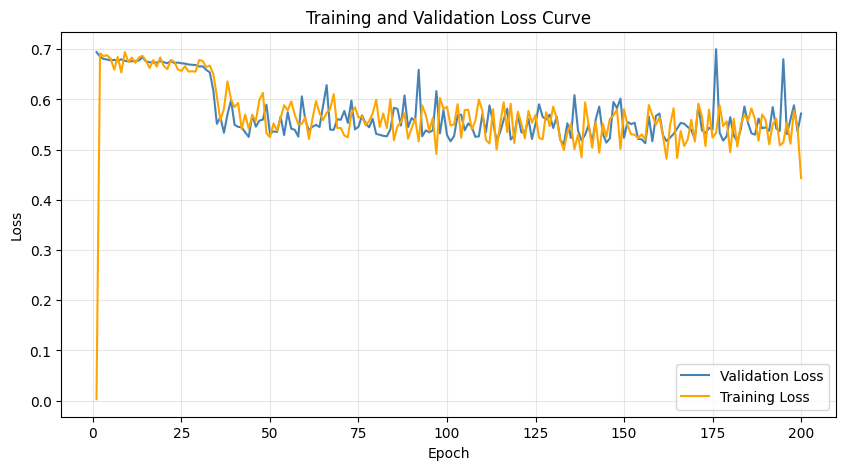

In [ ]:
# TODO: plot training and validation loss
# Your loss is stored at word_val_losses and word_train_losses

import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 201)
train_loss = word_train_losses
val_loss = word_val_losses

# Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, label='Validation Loss', color='steelblue')
plt.plot(epochs, train_loss, label='Training Loss', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



This is TA's example of training and validation loss curve (your curve might be slightly different) :

<img src='https://drive.google.com/uc?id=1n7tzqoOne_7tc3avmd2UWIQ9uq1s_jTp'>

In the plot above, both the training loss and validation loss exhibit similar trends, which is a positive sign, suggesting that the model is generalizing well to the unseen validation data.

From epoch 0 to 12500(x\*plot_every = 50\*250), the validation loss decreases slowly from 0.7 to 0.67, indicating a gradual learning process. At epoch 12500, there is a significant drop in validation loss to 0.55, suggesting that the model might have learned some crucial features or representations that considerably improved its performance on the validation set.

Post epoch 12500, the validation loss stabilizes and fluctuates around 0.55 till epoch 50000. This stabilization implies that the model has reached a plateau, and further training is not leading to significant improvements in loss reduction on the validation set.

# Section 2: Another classification: city names [22 points]

Now let's work with another classification example! We will use another dataset we are familiar with - Names of the Cities. The task is to predict the country a city is in.



### **Dataset Description**

Like we have used in the previous homework before, this dataset has a list of city names and their countries as label. The following countries are included in the dataset.

| Index | id | Country |
|----------|----------|----------|
| 0 | af | Afghanistan |
| 1 | cn | China |
| 2 | de | Germany |
| 3 | fi | Finland |
| 4 | fr | France |
| 5 | in | India |
| 6 | ir | Iran |
| 7 | pk | Pakistan |
| 8 | za | South Africa |

We need to re-define our 'group' first, since there are now 9 categories. Let's name it as 'languages'.

In [ ]:
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]

Let's also take a look at the dataset. We have finished some preprocessing for you, but each country label is in a string form, while tensor only accepts integer.

In [ ]:
city_train_data_raw = readData("/content/", train=True)
city_val_data_raw = readData("/content/", train=False)

X_city, y_city_str = city_train_data_raw
X_val_city, y_val_city_str = city_val_data_raw

seed = 12
local_random = np.random.RandomState(seed)
print(X_city[local_random.choice(len(X_city), 5, replace=False)])
local_random = np.random.RandomState(seed)
print(y_city_str[local_random.choice(len(y_city_str), 5, replace=False)])

['nyarkheyl' 'daxikou' 'galupadeh' 'maohezi' 'airport road']
['af' 'cn' 'de' 'cn' 'ir']


In order to do multiclass classification with PyTorch, please pre-process `y_city_str`, using the index-id mapping table provided above:


In [ ]:
# TODO: Please create y_city and y_val_city, where y is a NumPy array of corresponding integer index.
# Hint: use .index() function to find index of a value in a list
y_city = np.array([languages.index(x) for x in y_city_str])
y_val_city = np.array([languages.index(x) for x in y_val_city_str])



In [ ]:
assert y_city[10] == 0
assert y_city[10000] == 3
assert y_city[25000] == 8
assert y_val_city[10] == 0
assert y_val_city[100] == 1
assert y_val_city[500] == 5

In [ ]:
#DO NOT CHANGE
city_train_data = X_city, y_city
city_val_data = X_val_city, y_val_city


# PennGrader - DO NOT CHANGE
city_tests = [15, 12500, 19000]
city_val_tests = [5, 120, 480]
city_indices = [y_city[x] for x in city_tests]
city_val_indices = [y_val_city[x] for x in city_val_tests]
grader.grade(test_case_id = 'testIndexedY', answer = (city_indices,city_val_indices))

NameError: name 'grader' is not defined

### **Remake the model and functions: from binary to multiclass**

The model and functions we used in the previous example is made for binary classification, where output classes are only 0 and 1. In this problem, we have 8 different categories. What should we change? We need to make our model accepts multiple outputs dimension, which includes fixing `RNN()`, `predict()`, `calculateAccuracy()`, and `run()` function.

Let's start with the RNN model first. We assumed there were only 2 categories in RNN(), but now we have more than that. Please build RNN_multi() for multiclass classification.

In [ ]:

# Step wise learning rate. Once it plateaus you keep that learning rate. It fluctuates!

class RNN_multi(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        '''
        Multiclass RNN for character-level classification.
        Args:
            input_size: size of one-hot input vectors (e.g., n_letters)
            hidden_size: number of hidden units
            output_size: number of classes (e.g., len(languages))
        '''
        super(RNN_multi, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = torch.tanh(self.i2h(combined))  # <---- nonlinear activation
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, device='cpu'):
        return torch.zeros(1, self.hidden_size, device=device)


In [ ]:
# TEST - it should accept different output size! (Should be fine if there is no error)
RNN_multi(1,1,1)
RNN_multi(10,10,10)

RNN_multi(
  (i2h): Linear(in_features=20, out_features=10, bias=True)
  (h2o): Linear(in_features=10, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
# PennGrader - DO NOT CHANGE
test_models = [str(RNN_multi(100,100,100)), str(RNN_multi(20,20,20))]
grader.grade(test_case_id = 'testRNN_multi', answer = test_models)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


The `predict()` function we used was designed for binary classification only too. We need to fix how prediction is derived from `output` of the model.

HINT: We are using `nn.NLLLoss()` (negative log lokelihood), model's last layer is a logarithm of probabilities.

In [ ]:
def predict_multi(model, X, y=None, loss_func=None):
    model.eval()
    preds = []
    val_losses = []

    with torch.no_grad():
        for ind in range(len(X)):
            hidden = model.initHidden().to(device)
            val = lineToTensor(X[ind])
            if val.size()[0] == 0:
                continue  # skip empty input
            output = torch.zeros(1, len(languages)).to(device)
            for i in range(val.size()[0]):
                output, hidden = model(val[i], hidden)
            _, prediction = torch.max(output, 1)
            preds.append(prediction.item())


            # Optionally compute validation loss
            if y is not None and loss_func is not None:
                category_tensor = torch.tensor([int(y[ind])]).to(device)
                val_losses.append(loss_func(output, category_tensor).item())

    if y is not None and loss_func is not None:
        return sum(val_losses) / len(val_losses)
    return np.array(preds)


Let's also update `calculateAccuracy()` function, where `predict_multi()` shuould be updated.

In [ ]:
def calculateAccuracy_multi(model, X, y):
    preds = predict_multi(model, X)

    return accuracy_score(y, preds)

Finally, let's update `run()` function to address the changes we have made above.

In [ ]:
def run_multi(train_data, val_data, hidden_size, n_epochs, learning_rate, loss_func, print_every, plot_every, model_name):
    X, y = train_data
    X_val, y_val = val_data
    # TODO: add RNN_multi() here
    model = RNN_multi(input_size=len(all_letters), hidden_size=hidden_size, output_size=len(languages))
    model = model.to(device)
    current_loss = 0
    train_losses = []
    val_losses = []
    optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
    for epoch in range(0, n_epochs):
        output, loss, line, category = trainOneEpoch(model,
                    criterion = loss_func,
                    optimizer = optimizer,
                    X=X,
                    y=y)
        current_loss += loss


        if epoch % print_every == 0:
            # TODO: design your own report to print (freestyle!)
            # What you can do:
            #   1. make prediction
            #   2. compare with gold label to see right or wrong
            #   3. report the number of epoch, the percentage of completion, loss,...

            log_probabilities = output.cpu().data
            _, prediction = torch.max(log_probabilities, 1)
            predicted_label = prediction.item()
            true_label = category if isinstance(category, int) else category.item()
            correct = 'correct' if predicted_label == true_label else 'incorrect (True:%s)' % category
        else:
          pass

        if epoch % plot_every == 0:
            train_losses.append(current_loss/plot_every)
            current_loss= 0

            # Validation Loss
            # TODO: update with predict_multi() function
            val_losses.append(predict_multi(model, X_val, y_val, loss_func))


    torch.save(model.state_dict(), model_name)
    return train_losses, val_losses

### **Test the new model**

Let's test our model with these hyperparameters first. They are not great, but we will tune them later.

In [ ]:
# This will take around 7 mins
city_all_losses, city_val_losses = run_multi(train_data = city_train_data,
                              val_data = city_val_data,
                              hidden_size = 10,
                              n_epochs = 50000,
                              learning_rate = 0.01,
                              loss_func = nn.NLLLoss(),
                              print_every = 5000,
                              plot_every = 250,
                              model_name = "./city_RNN"
                            )

In [ ]:
# Load saved model
test_model_multi = RNN_multi(input_size=len(all_letters), hidden_size=10, output_size=len(languages)).to(device)
test_model_multi.load_state_dict(torch.load("./city_RNN"))

<All keys matched successfully>

As we have done before, please calculate validation accuracy and draw a training and validation loss plot.

In [ ]:
test_model_multi.eval()
# TODO: Compute Validation accuracy. Tip: `city_val_data` is the validation dataset!
print(len(city_val_data[0]), len(city_val_data[1]))
val_acc = calculateAccuracy_multi(test_model_multi, city_val_data[0], city_val_data[1])
print(val_acc)

900 900
0.38333333333333336


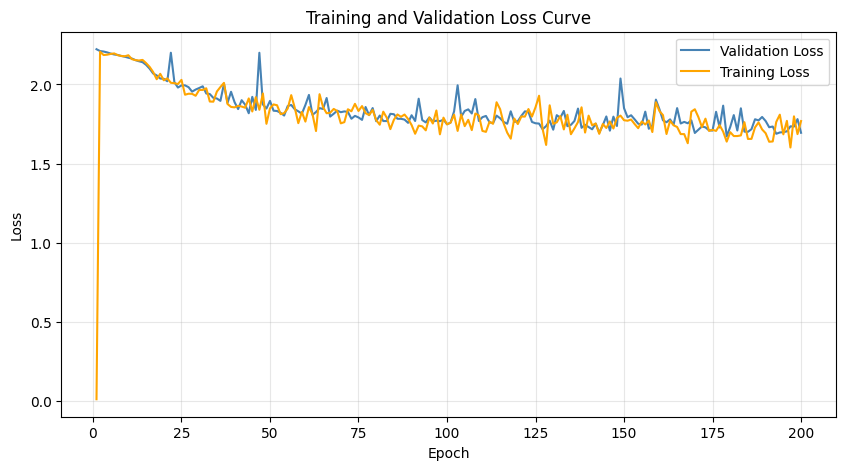

In [ ]:
# TODO: Draw training and validation loss plot

epochs = np.arange(1, 201)
train_loss = city_all_losses
val_loss = city_val_losses

# Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, label='Validation Loss', color='steelblue')
plt.plot(epochs, train_loss, label='Training Loss', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### **Hyperparameter tuning**

The current set of hyperparameters will very likely to make your model generate `Nan` loss, and it often does not learn the data well. What is the problem? The main reason is the model we used in word classification is not suitable for this task. Your main goal in this section is improving the model with "hyperparameter tuning".

We now have 3 hyperparameters to tune:   
1. **learning_rate** represents how fast the model learn for each backpropagation. The higher a value, the faster a model converges. However if a learning rate is too high, it will cause a lot of problems like overshooting (can't converge, bouncing around the minimum) or divergence (loss goes to infinity).
2. **hidden_size** defines the size of the hidden layer in your RNN model. The larger the size, the more complex model can be (and slower).
3. **n_epochs** controls the number of epoch the model use for training. The more we train, the more it learns from training dataset (and takes longer time). Becareful for overfitting!


Please do the experiments below, and write your finding in another file to uploaded as a PDF.

### **Task 2.1:** learning rate tunning [6 points]

From the base hyperparameters we gave, adjust the learning_rate = {0.0002, 0.002 0.02} and compare the result, what have you found?

lr=0.0002  |  val accuracy: 0.1600


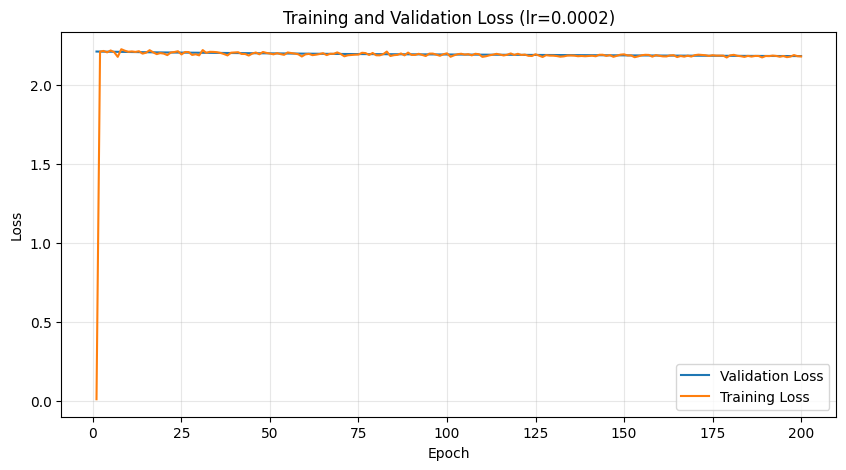

lr=0.002  |  val accuracy: 0.3244


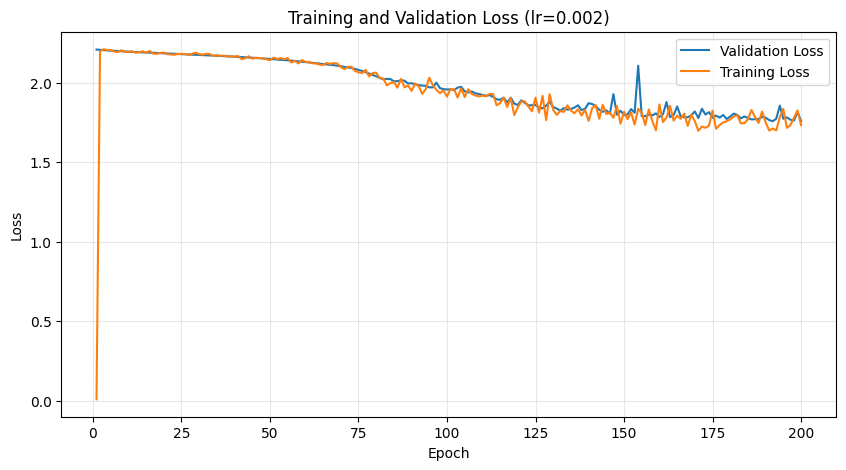

lr=0.02  |  val accuracy: 0.1900


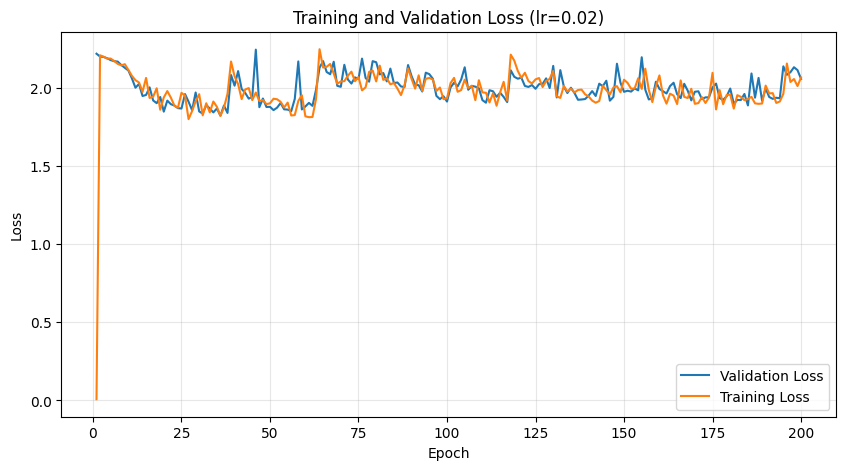

In [ ]:
lrs = [0.0002, 0.002, 0.02]

for lr in lrs:
    ckpt = f"./city_RNN_lr{lr:g}"

    # Train with this learning rate
    city_all_losses, city_val_losses = run_multi(
        train_data=city_train_data,
        val_data=city_val_data,
        hidden_size=10,
        n_epochs=50000,
        learning_rate=lr,
        loss_func=nn.NLLLoss(),
        print_every=5000,
        plot_every=250,
        model_name=ckpt
    )

    # Fresh model
    test_model_multi = RNN_multi(
        input_size=len(all_letters),
        hidden_size=10,
        output_size=len(languages)
    ).to(device)

    # Load trained weights
    state = torch.load(ckpt, map_location=device)
    test_model_multi.load_state_dict(state)
    test_model_multi.eval()

    with torch.no_grad():
        acc = calculateAccuracy_multi(test_model_multi, city_val_data[0], city_val_data[1])

    print(f"lr={lr:g}  |  val accuracy: {acc:.4f}")

    # Plot (match x-axis to returned loss lengths)
    epochs = np.arange(1, len(city_val_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, city_val_losses, label='Validation Loss')
    plt.plot(epochs, city_all_losses, label='Training Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (lr={lr:g})')
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()


### **Task 2.2:** hidden layer size tunning [6 points]

With the best learning rate you have, build models with hidden_size = {10, 50, 100} and compare the result, what have you found?

Hidden Layer=10  |  val accuracy: 0.3556


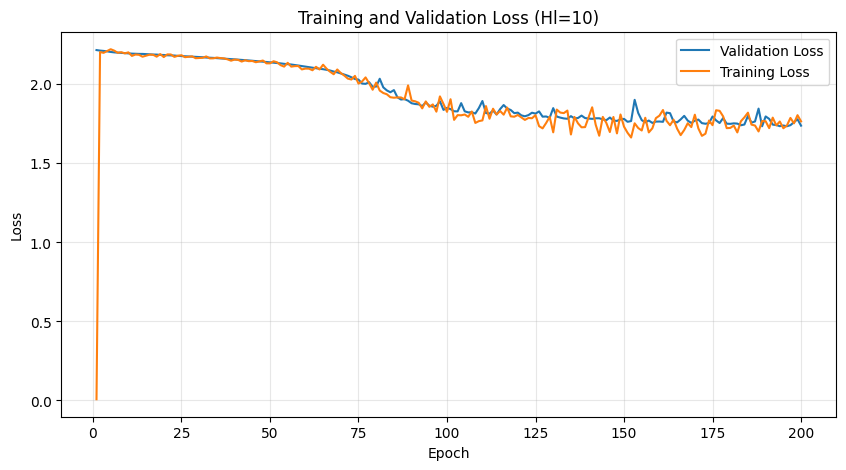

Hidden Layer=50  |  val accuracy: 0.4233


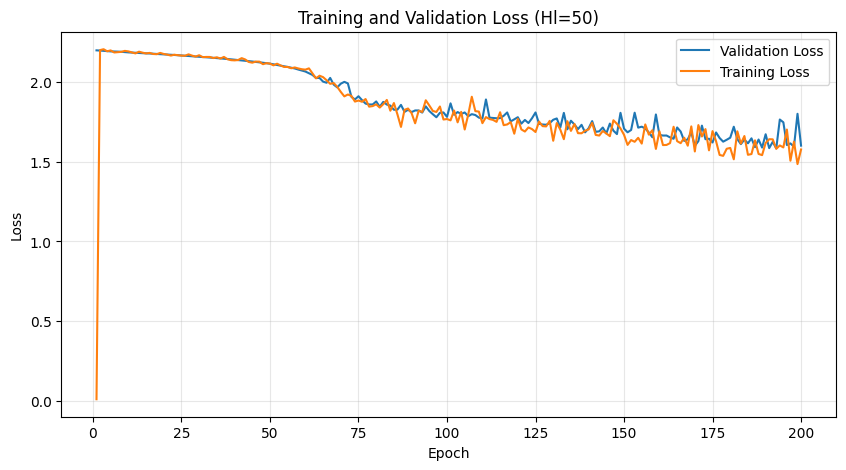

Hidden Layer=100  |  val accuracy: 0.4178


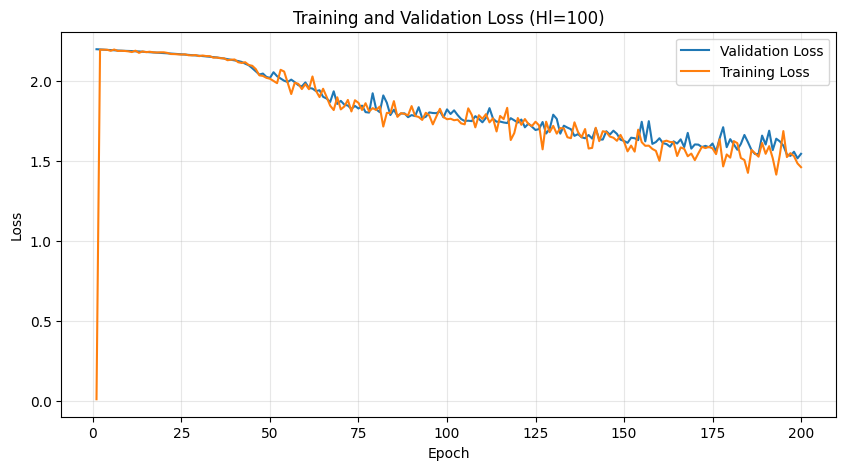

In [ ]:
hlrs = [10,50,100]

for hl in hlrs:
    ckpt = f"./city_RNN_lr{hl:g}"

    # Train with this learning rate
    city_all_losses, city_val_losses = run_multi(
        train_data=city_train_data,
        val_data=city_val_data,
        hidden_size=hl,
        n_epochs=50000,
        learning_rate=.002,
        loss_func=nn.NLLLoss(),
        print_every=5000,
        plot_every=250,
        model_name=ckpt
    )

    # Wipe the model, ensure no carryover data
    test_model_multi = RNN_multi(
        input_size=len(all_letters),
        hidden_size=hl,
        output_size=len(languages)
    ).to(device)

    # Load trained weights
    state = torch.load(ckpt, map_location=device)
    test_model_multi.load_state_dict(state)
    test_model_multi.eval()

    with torch.no_grad():
        acc = calculateAccuracy_multi(test_model_multi, city_val_data[0], city_val_data[1])

    print(f"Hidden Layer={hl:g}  |  val accuracy: {acc:.4f}")

    # Plot (match x-axis to returned loss lengths)
    epochs = np.arange(1, len(city_val_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, city_val_losses, label='Validation Loss')
    plt.plot(epochs, city_all_losses, label='Training Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (Hl={hl:g})')
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()

### **Task 2.3:** epoch tuning [6 points]

With the best learnign rate and hidden_size you got, adjust the model with epoch = {1000, 50000, 100000} and compare the result, what have you found?

Epoch=1000  |  val accuracy: 0.1256


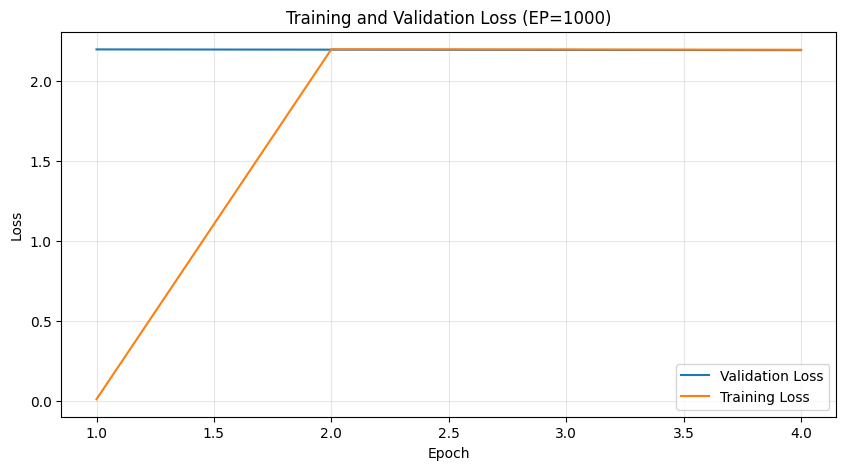

Epoch=50000  |  val accuracy: 0.4111


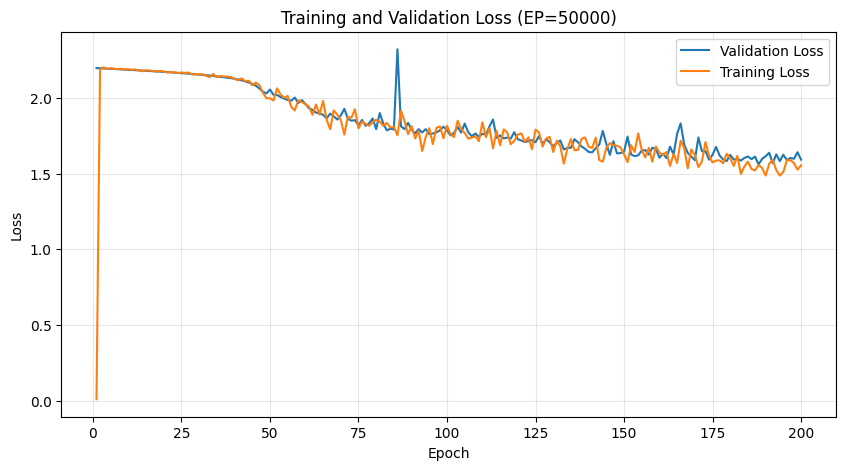

Epoch=100000  |  val accuracy: 0.5033


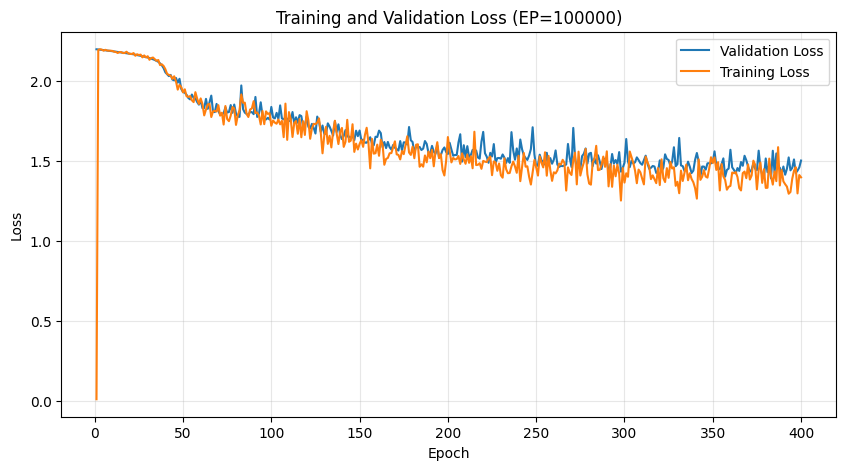

In [ ]:
hlrs = [1000, 50000, 100000]

for hl in hlrs:
    ckpt = f"./city_RNN_lr{hl:g}"

    # Train with this learning rate
    city_all_losses, city_val_losses = run_multi(
        train_data=city_train_data,
        val_data=city_val_data,
        hidden_size=100,
        n_epochs=hl,
        learning_rate=.002,
        loss_func=nn.NLLLoss(),
        print_every=5000,
        plot_every=250,
        model_name=ckpt
    )

    # Wipe the model, ensure no carryover data
    test_model_multi = RNN_multi(
        input_size=len(all_letters),
        hidden_size=100,
        output_size=len(languages)
    ).to(device)

    # Load trained weights
    state = torch.load(ckpt, map_location=device)
    test_model_multi.load_state_dict(state)
    test_model_multi.eval()

    with torch.no_grad():
        acc = calculateAccuracy_multi(test_model_multi, city_val_data[0], city_val_data[1])

    print(f"Epoch={hl:g}  |  val accuracy: {acc:.4f}")

    # Plot (match x-axis to returned loss lengths)
    epochs = np.arange(1, len(city_val_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, city_val_losses, label='Validation Loss')
    plt.plot(epochs, city_all_losses, label='Training Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (EP={hl:g})')
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()

## **Task 2.4(optional):** Leaderboard

There are still a lot of other items you can adjust:
1. Model structure (number of layers, type of layers)
2. Optimizer: SGD, Adagrad, Adam, ...
3. Criterion(loss function): MSE, Cross-Entropy Loss, ...
4. And even more...

Try to make your best model and compete with others! Write code to make predictions on the provided test set `cities_test.txt`. The test set has one unlabeled city name per line. Your code should output a file `labels.txt` with one two-letter country code per line. Make sure your test accuracy can pass the auto-grader and then experiment to achieve higher values. Extra credit (5 points) will be given to the top 5 leaderboard submissions. Here are some ideas for improving your leaderboard performance:

 - Try dropout if your model is overfitting
 - Experiment with different loss functions, optimizers
 - Compare the different types of RNNs - RNN, LSTM, GRU units.
 - Use a different initalization for the weights, for example, small random values instead of 0s

In your report, describe your final model and training parameters.

Another tip for experimenting with neural network hyperparameters is to maintain notes (e.g. a spreadsheet or text-file) with different parameters and their resulting accuray. As you can imagine, there is a combinatorial explosion of the possible hyperparameter space so navigating it efficiently is best done by remembering your past experiments. Feel free to include this in your report as well.

[0] loss=2.2893 correct=False
 new best val loss 2.0491 at epoch 250
 new best val loss 1.8824 at epoch 500
 new best val loss 1.7897 at epoch 750
 new best val loss 1.7591 at epoch 1000
 new best val loss 1.6774 at epoch 1250
 new best val loss 1.6462 at epoch 1500
 new best val loss 1.5950 at epoch 1750
 new best val loss 1.5728 at epoch 2250
 new best val loss 1.4937 at epoch 2500
 new best val loss 1.4882 at epoch 2750
 new best val loss 1.4265 at epoch 3000
 new best val loss 1.4142 at epoch 3250
 new best val loss 1.3756 at epoch 3750
 new best val loss 1.3354 at epoch 4000
 new best val loss 1.3227 at epoch 4250
 new best val loss 1.3191 at epoch 4750
[5000] loss=0.0897 correct=True
 new best val loss 1.2579 at epoch 5000
 new best val loss 1.2491 at epoch 5500
 new best val loss 1.2281 at epoch 6000
 new best val loss 1.2031 at epoch 6250
 new best val loss 1.1949 at epoch 6500
 new best val loss 1.1734 at epoch 7750
 new best val loss 1.1510 at epoch 9000
 new best val loss 1.

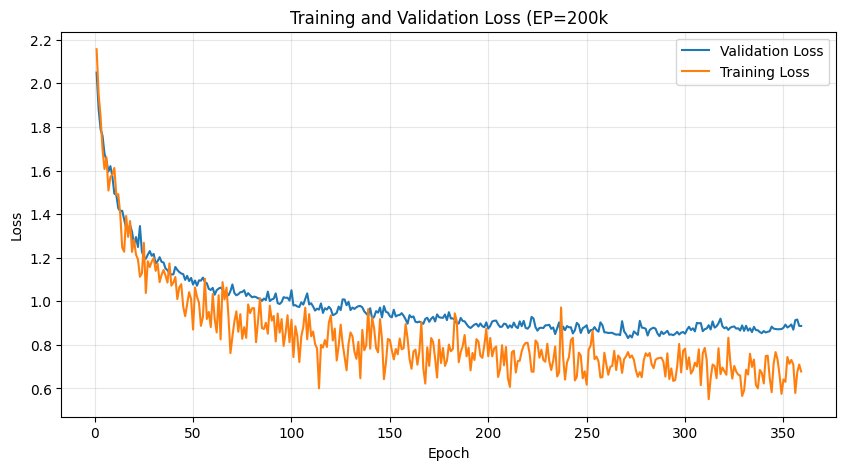

In [ ]:
# # TODO(optional):


def lineToTensor(line):
    """Convert a string line into a tensor of character indices (for Embedding input)."""
    indices = []
    for ch in line:
        idx = all_letters.find(ch)
        if idx == -1:   # if character not found
            idx = 0     # map to a safe 'unknown' index
        indices.append(idx)

    # Shape: (seq_len, 1)
    return torch.tensor(indices, dtype=torch.long, device=device).unsqueeze(1)

def trainOneEpoch(model, criterion, optimizer, X, y):
    optimizer.zero_grad()

    category, line, category_tensor, line_tensor = random_training_pair(X, y)

    if hasattr(model, "initHiddenCell"):
        hidden, cell = model.initHiddenCell()
        for i in range(line_tensor.size(0)):
            output, (hidden, cell) = model(line_tensor[i].unsqueeze(0), hidden, cell)
    else:
        hidden = model.initHidden()
        for i in range(line_tensor.size(0)):
            output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item(), line, category


def predict_multi(model, X, y=None, loss_func=None):
    model.eval()
    preds = []
    val_losses = []

    with torch.no_grad():
        for ind in range(len(X)):
            val = lineToTensor(X[ind])
            if val.size(0) == 0:
                continue

            # Handle both model types
            if hasattr(model, "initHiddenCell"):
                hidden, cell = model.initHiddenCell()
            else:
                hidden = model.initHidden()

            for i in range(val.size(0)):
                if hasattr(model, "initHiddenCell"):
                    output, (hidden, cell) = model(val[i].unsqueeze(0), hidden, cell)
                else:
                    output, hidden = model(val[i], hidden)

            # Get prediction index
            _, pred = output.topk(1)
            preds.append(pred.item())

            # Optionally compute validation loss
            if y is not None and loss_func is not None:
                category_tensor = torch.tensor([int(y[ind])]).to(device)
                val_losses.append(loss_func(output, category_tensor).item())

    # Return both depending on context
    if y is not None and loss_func is not None:
        return sum(val_losses) / len(val_losses)
    else:
        return preds





def run_multi2(train_data, val_data, model2, n_epochs, learning_rate, loss_func, print_every, plot_every, model_name):
    X, y = train_data
    X_val, y_val = val_data
    model = model2.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    train_losses, val_losses = [], []
    current_loss, best_val = 0.0, float('inf')

    model.train()
    for epoch in range(n_epochs):
        output, loss, line, category = trainOneEpoch(model, loss_func, optimizer, X, y)
        current_loss += loss

        if epoch % print_every == 0:
            lp = output.detach().cpu()
            _, pred = torch.max(lp, 1)
            pred_label = pred.item()
            true_label = category if isinstance(category, int) else category.item()
            print(f"[{epoch}] loss={loss:.4f} correct={pred_label==true_label}")

        if epoch % plot_every == 0 and epoch > 0:
            train_losses.append(current_loss / plot_every)
            current_loss = 0.0

            model.eval()
            v = predict_multi(model, X_val, y_val, loss_func)
            val_losses.append(v)
            if v < best_val:
                best_val = v
                torch.save(model.state_dict(), model_name)
                print(f" new best val loss {best_val:.4f} at epoch {epoch}")
            model.train()

    # also save last state if you want
    # torch.save(model.state_dict(), model_name + ".last")
    return train_losses, val_losses

class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden):
        # input_tensor: (1, input_size)
        output, hidden = self.gru(input_tensor, hidden)
        output = self.fc(output[-1])
        output = output.unsqueeze(0)
        output = self.log_softmax(output)
        return output, hidden

    def initHidden(self):
        # Hidden must be 2D for unbatched GRU input
        return torch.zeros(1, self.hidden_size, device=device)


class LSTMClassifier(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size, dropout=0.3, num_layers=2):
        """
        Enhanced LSTM classifier for character-level city→country prediction.

        Args:
            input_size (int): Number of unique characters (len(all_letters))
            embedding_dim (int): Dimensionality of character embeddings (e.g., 32)
            hidden_size (int): Number of hidden units in the LSTM (e.g., 200)
            output_size (int): Number of output classes (len(languages))
            dropout (float): Dropout rate between LSTM and FC layers (default 0.3)
            num_layers (int): Number of stacked LSTM layers (default 1)
        """
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_dim)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
        )


        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)


        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden, cell):
        """
        input_tensor: (seq_len, batch_size) of integer character indices
        hidden: (num_layers, batch_size, hidden_size)
        cell: (num_layers, batch_size, hidden_size)
        """
        embedded = self.embedding(input_tensor)             # (seq_len, batch, embed_dim)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        output = self.dropout(output[-1])                   # last time step
        output = self.fc(output)
        output = self.log_softmax(output)     # (1, output_size)
        return output, (hidden, cell)

    def initHiddenCell(self, batch_size=1):
        """Initialize hidden and cell states to zeros."""
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        return hidden, cell



ckpt = f"./city_RNN_lr500000"

# Wipe the model, ensure no carryover data
test_model_multi = GRUClassifier(
    input_size=len(all_letters),
    hidden_size=100,
    output_size=len(languages)
).to(device)


# Train with this learning rate
# Model setup
test_model_multi = LSTMClassifier(
    input_size=len(all_letters),
    embedding_dim=96,
    hidden_size=125,
    output_size=len(languages)
).to(device)

# Training
city_all_losses, city_val_losses = run_multi2(
    train_data=city_train_data,
    val_data=city_val_data,
    model2=test_model_multi,
    n_epochs=90000,
    learning_rate=.0005,
    loss_func=nn.NLLLoss(),
    print_every=5000,
    plot_every=250,
    model_name=ckpt
)

with open("cities_test.txt", "r", encoding = "latin-1") as test_file:
    lines = [line.strip() for line in test_file]

test_model_multi.eval()

# Load trained weights
state = torch.load(ckpt, map_location=device)
test_model_multi.load_state_dict(state)
test_model_multi.eval()


# Label prediction
with open("labels.txt", "w") as output_file:
    with torch.no_grad():
        for city in lines:
            input_tensor = lineToTensor(city)
            hidden, cell = test_model_multi.initHiddenCell()
            for i in range(input_tensor.size(0)):
                output, (hidden, cell) = test_model_multi(input_tensor[i].unsqueeze(0), hidden, cell)
            pred_idx = output.topk(1)[1].item()
            output_file.write(languages[pred_idx] + "\n")



# Load trained weights
state = torch.load(ckpt, map_location=device)
test_model_multi.load_state_dict(state)
test_model_multi.eval()

with torch.no_grad():
    acc = calculateAccuracy_multi(test_model_multi, city_val_data[0], city_val_data[1])
print(acc)
# print(f"Epoch={hl:g}  |  val accuracy: {acc:.4f}")

# Plot (match x-axis to returned loss lengths)
epochs = np.arange(1, len(city_val_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, city_val_losses, label='Validation Loss')
plt.plot(epochs, city_all_losses, label='Training Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title(f'Training and Validation Loss (EP=200k')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()





# fi = open("labels.txt", "r")
# for f in fi:
#     print(f)
# fi.close()


# Submission
### Congratulation on finishing your homework! Here are the deliverables you need to submit to GradeScope:

  - `writeup.pdf`: including Task 2.1, 2.2, and 2.3
    - 2.4(optional)
  - `homework6.ipynb`: This .ipynb notebook
  - `homework6.py`: .py file of this notebook
  - `labels.txt`: predictions for leaderboard (optional).